# Control moment gyroscope (AE 353 Project 1)

Import modules and configure the notebook.

In [1]:
# This module is part of the python standard library
import time

# These modules are part of other existing libraries
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
from scipy import linalg

# Given pybullet script (it is an interface to the pybullet simulator)
import ae353_cmg

import importlib
importlib.reload(ae353_cmg)

<module 'ae353_cmg' from 'c:\\Users\\anshu\\Desktop\\Class Materials\\AE 353 Git\\ae353-sp21\\projects\\01_cmg\\ae353_cmg.py'>

In this notebook, the following steps will be taken to generate all the results for the project.
* Linearize the system
* Find the eigenvalues of F for different values of K
* Pick value of K that gives negative eigenvalues for F
* Run the simulation in pybullet with the calculated K gains
* Plot the results

## Linearizing the System

In [2]:
#All the required symbols
q1,q2,v1,v2,v3,tau2,tau3 = sym.symbols('q1,q2,v1,v2,v3,tau2,tau3')
#The provided equations of motion
f = sym.Matrix([[v1],[-(5*(200*tau3*sym.sin(q2)+sym.sin(2*q2)*v1*v2+2*sym.cos(q2)*v2*v3)/(10*(sym.sin(q2))**2 -511))],[v2],[10/11 * (100*tau2 - sym.cos(q2)*v1*v3)],[-((51100*tau3+5*sym.sin(2*q2)*v2*v3+511*sym.cos(q2)*v1*v2)/(10*(sym.sin(q2))**2 -511))]])
# Make f and executable function
f_num = sym.lambdify((q1,q2,v1,v2,v3,tau2,tau3), f)

In [3]:
# See F
f

Matrix([
[                                                                               v1],
[-(1000*tau3*sin(q2) + 5*v1*v2*sin(2*q2) + 10*v2*v3*cos(q2))/(10*sin(q2)**2 - 511)],
[                                                                               v2],
[                          90.9090909090909*tau2 - 0.909090909090909*v1*v3*cos(q2)],
[      -(51100*tau3 + 511*v1*v2*cos(q2) + 5*v2*v3*sin(2*q2))/(10*sin(q2)**2 - 511)]])

### Equilibrium values
* q1 is not in any of the equations, so it can be anything, let's make it about 45 degrees (desired angle)
* v3 can also be anything, but since we're starting off at 100 rpm, I set it as that.

In [4]:
q1_e = 45*np.pi/180
q2_e = 0
v1_e = 0
v2_e = 0
v3_e = 10.472 #100 rpm, starting v3
tau2_e = 0
tau3_e = 0

In [5]:
#checking if the equilibrium points work:
f_eq = f_num(q1_e,q2_e,v1_e,v2_e,v3_e,tau2_e,tau3_e)
f_eq #evaluates to 0! Nice!

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]])

Now we are ready to linearize the system.

In [6]:
#Now we find the Jacobians
f_jacob_x = f.jacobian([q1,q2,v1,v2,v3])
f_jacob_u = f.jacobian([tau2,tau3])

#And then we find functions for A and B using this jacobian
A_num = sym.lambdify((q1,q2,v1,v2,v3,tau2,tau3),f_jacob_x)
B_num = sym.lambdify((q1,q2,v1,v2,v3,tau2,tau3),f_jacob_u)

#Finally, we find the linearized state space model by evaluating A_num and B_num at the equilibrium points
A = A_num(q1_e,q2_e,v1_e,v2_e,v3_e,tau2_e,tau3_e).astype(float)
B = B_num(q1_e,q2_e,v1_e,v2_e,v3_e,tau2_e,tau3_e).astype(float)

With all these steps, we have linearized our equations of motions about the chosen equilibrium point to create a state space model.

In [7]:
# See A
A

array([[ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.        ,  0.20493151, -0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ],
       [ 0.        ,  0.        , -9.52      ,  0.        , -0.        ],
       [ 0.        ,  0.        , -0.        ,  0.        , -0.        ]])

In [8]:
# See B
B

array([[  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [ 90.90909091,   0.        ],
       [  0.        , 100.        ]])

## Finding Stable Controller Gains

We still have not covered a method to efficiently calculate working K gains. Therefore, here we resort to using random numbers. There are some values in K that are set to 0 as a design choice based on the system. More information on that in the report.

In [9]:
# The next section is commented out because I already found the K gains I wanted. But this shows the process used.
'''i = 0
while i == 0:
    K = np.array([[np.random.rand(),np.random.rand(),np.random.rand(),np.random.rand(),0],[0,0,0,0,np.random.rand()]])
    F  = A - B@K
    s = linalg.eigvals(F)
    if (s.real < 0).all() and (s.imag == 0).all():
        i += 1'''
# Good K gains
K = np.array([[0.8085914584901315, 0.1356123563018472, 0.748872791294181, 0.2593557597971461, 0.0], [0.0, 0.0, 0.0, 0.0, 0.9166361309236439]])
F  = A - B@K
s = linalg.eigvals(F)
print(K.tolist())
s

[[0.8085914584901315, 0.1356123563018472, 0.748872791294181, 0.2593557597971461, 0.0], [0.0, 0.0, 0.0, 0.0, 0.9166361309236439]]


array([-1.96998847e+01+0.j, -2.10670987e+00+0.j, -1.77120183e+00+0.j,
       -3.13077743e-16+0.j, -9.16636131e+01+0.j])

## Running the Simulation
Now we are ready to run the actual simulation. Most of this is taken from CMGDemo.ipynb. The major changes are in the controller definition.

### Creating an instance of the robot simulator
There are three optional parameters:

* `damping` is the coefficient of viscouse friction at each joint (the default value is `0.`)
* `dt` is the length of each time step in the simulator (the default value is `0.001`)
* `display` is a flag that says whether or not to open the GUI (the default value is `True`)

The `display` parameter, in particular, is likely to be of use to you. If you set `display=True`, then you will run the simulator in real-time with a GUI. If you set `display=False`, then you will run the simulator as fast as possible (faster than real-time) without a GUI. This is convenient when all you want is the data.

**NOTE:** it is still necessary to reset the kernel (see the "Kernel" menu above) before creating a new instance of the robot simulator, even when running without a GUI - if you don't, then you'll notice that simulation slows way down.

In [10]:
robot = ae353_cmg.RobotSimulator(damping=0., dt=0.001, display=True)


### Some useful notes from the EOM notebook.

Joint angles:

* q1 is the angle of the "outer" link. This is what we want to control and get to a particular angle
The goal of this project is going to be to get this angle to 45 degrees.

* q2 is the angle of the "inner" link

* q3 is the angle of the wheel

The same order applies to the velocities.

Define and create an instance of the robot controller. 

In [11]:
class RobotController:
    def __init__(self, dt=0.001, q1_des = 45*np.pi/180):
        self.dt = dt #Timestep property of the RobotController class

        #Desired angles and velocities and the gain matrix
        self.K = np.array([[0.8085914584901315, 0.1356123563018472, 0.748872791294181, 0.2593557597971461, 0.0], [0.0, 0.0, 0.0, 0.0, 0.9166361309236439]])
        self.q1_des = q1_des
        self.q2_des = 0
        self.v1_des = 0
        self.v2_des = 0
        self.v3_des = 50 #rad/s

    def run(self, q_1, v_1, q_2, v_2, q_3, v_3):
        #state
        x = np.array([[q_1 - self.q1_des],[v_1 - self.v1_des],[q_2 - self.q2_des], [v_2 - self.v2_des],[v_3 - self.v3_des]])

        #input
        u = - self.K @ x

        tau_2 = u[0,0] # <-- torque applied to gimbal. 
        tau_3 = u[1,0] # <-- torque applied to rotor.
        #tau_3 = 0.
        return tau_2, tau_3

controller = RobotController(dt=robot.dt)

Run the simulation. It is a loop. At each iteration, we:
* get sensor measurements
* choose actuator commands
* go forward one time step

We also log data so that we can plot it later, if we want.

In [12]:
# Restore the simulation to its initial state
# Random initial state
# robot.set_state(np.random.randn(3), np.random.randn(3))
# Default initial state
robot.reset(rotor_rpm=100.)

# Choose how long we want to run the simulation, and
# compute the corresponding number of time steps
run_time = 10.
num_steps = int(run_time/robot.dt)

# Create a dictionary in which to store results
data = {
    't': np.empty(num_steps, dtype=float),
    'q_1': np.empty(num_steps, dtype=float),
    'v_1': np.empty(num_steps, dtype=float),
    'q_2': np.empty(num_steps, dtype=float),
    'v_2': np.empty(num_steps, dtype=float),
    'q_3': np.empty(num_steps, dtype=float),
    'v_3': np.empty(num_steps, dtype=float),
    'tau_2': np.empty(num_steps, dtype=float),
    'tau_3': np.empty(num_steps, dtype=float),
}

# Run the simulation loop
start_time = time.time()
for step in range(num_steps):
    # Get the current time
    t = robot.dt * step
    
    # Get the sensor measurements
    q_1, v_1, q_2, v_2, q_3, v_3 = robot.get_sensor_measurements()
    
    # Choose the actuator command (by running the controller)
    tau_2, tau_3 = controller.run(q_1, v_1, q_2, v_2, q_3, v_3)
    
    # Log the data from this time step
    data['t'][step] = t
    data['q_1'][step] = q_1
    data['v_1'][step] = v_1
    data['q_2'][step] = q_2
    data['v_2'][step] = v_2
    data['q_3'][step] = q_3
    data['v_3'][step] = v_3
    data['tau_2'][step] = tau_2
    data['tau_3'][step] = tau_3
    
    # Send the actuator commands to robot and go forward one time
    # step (this is where the actual simulation happens)
    robot.set_actuator_commands(tau_2, tau_3)
    robot.step(t=(start_time + (robot.dt * (step + 1))))

## Plotting the Results

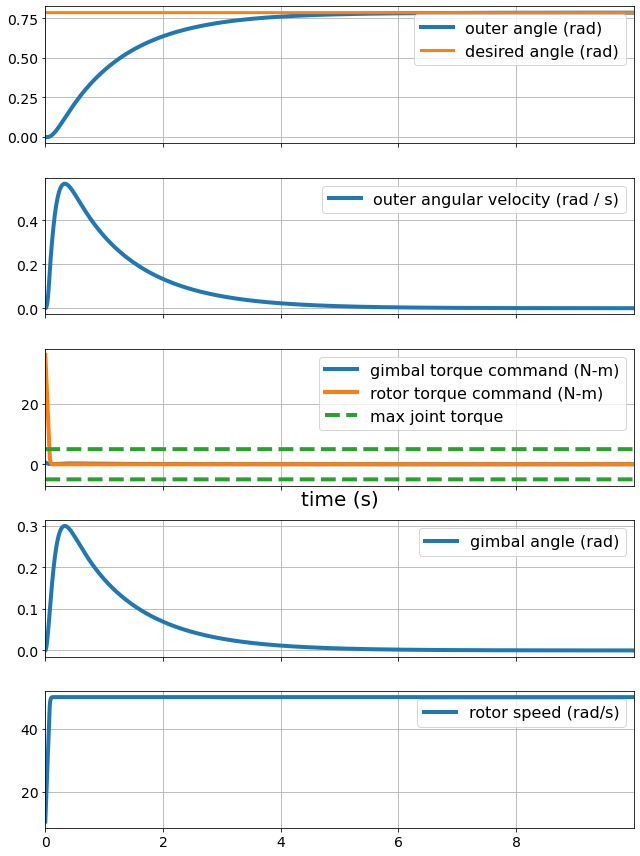

In [13]:
# Create a figure with three subplots, all of which share the same x-axis
fig, ax = plt.subplots(5, 1, figsize=(9, 12), sharex=True)

# Plot angle of outer gimbal on first subplot
ax[0].plot(data['t'], data['q_1'], label='outer angle (rad)', linewidth=4)
ax[0].plot(data['t'], np.ones_like(data['t']) * controller.q1_des, label='desired angle (rad)', linewidth=3)
ax[0].grid()
ax[0].legend(fontsize=16)
ax[0].tick_params(labelsize=14)

# Plot angular velocity of outer gimbal on second subplot
ax[1].plot(data['t'], data['v_1'], label='outer angular velocity (rad / s)', linewidth=4)
ax[1].grid()
ax[1].legend(fontsize=16)
ax[1].tick_params(labelsize=14)

# Plot torques on third subplot
ax[2].plot(data['t'], data['tau_2'], label='gimbal torque command (N-m)', linewidth=4)
ax[2].plot(data['t'], data['tau_3'], label='rotor torque command (N-m)', linewidth=4)
ax[2].plot(data['t'], np.ones_like(data['t']) * robot.tau_max, '--', label='max joint torque', linewidth=4, color='C2')
ax[2].plot(data['t'], -np.ones_like(data['t']) * robot.tau_max, '--', linewidth=4, color='C2')
ax[2].grid()
ax[2].legend(fontsize=16)
ax[2].tick_params(labelsize=14)
#ax[2].set_ylim(-1.2 * robot.tau_max, 1.2 * robot.tau_max)

# Plot gimbal angle on fourth subplot
ax[3].plot(data['t'], data['q_2'], label='gimbal angle (rad)', linewidth=4)
ax[3].grid()
ax[3].legend(fontsize=16)
ax[3].tick_params(labelsize=14)

# Plot rotor speed to see the effectiveness
ax[4].plot(data['t'], data['v_3'], label='rotor speed (rad/s)', linewidth=4)
ax[4].grid()
ax[4].legend(fontsize=16)
ax[4].tick_params(labelsize=14)

# Set x-axis properties (only need to do this on the fourth
# subplot since all four subplots share the same x-axis)
ax[2].set_xlabel('time (s)', fontsize=20)
ax[2].set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()